<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# Correlation Consumer Price Index with Distaster Events
* Project: <a href="https://www.femoz.de/">FEMOZ</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   08.08.2022

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
This notebook shows how to correlate price index data for food as well as health expenditures with data about the occurence of disasters. The number of total affected people serves as a measure for the severity of the disaster, hence this is the time series the other two got correlated with.  

### <font color="red">ToDos</font>:
* get the concept transferred to Mutual Information instead of Spearman Correlation
* set the x-axis back to 'date' instead of 'frame'
* read two time series and merge them together by date. Make sure you are correlating the disaster in the right region with the right market place.
    * one time series for disasters
    * one time series for prices
* filter also the disaster type "Drought" and "Flood" before correlation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from   sklearn.preprocessing import MinMaxScaler

sns.set_context('talk',font_scale=.8)

df = pd.read_csv('data.csv', sep=",", usecols=['total', 'food_products', 'health', 'total_affected'])

df = df.astype(float)
print(df.head)
df.dtypes

<bound method NDFrame.head of       total  food_products    health  total_affected
0     67.34         137.82   5505.52          3500.0
1     68.27         141.21   5448.97        447770.0
2     68.55         141.86   5433.79             0.0
3     68.97         142.90   5425.52             0.0
4     69.29         142.74   5407.59             0.0
..      ...            ...       ...             ...
167  185.41         483.40  11783.37       2700000.0
168  187.59         495.92  11809.29        481901.0
169  190.11         510.70  11801.02         11410.0
170  191.74         519.08  11789.22             0.0
171  191.68         515.08  11802.19             0.0

[172 rows x 4 columns]>


total             float64
food_products     float64
health            float64
total_affected    float64
dtype: object

In [2]:
'''every sklearn's transform's fit() just calculates the parameters 
(e.g. μ and σ in case of StandardScaler) and saves them as an internal objects state. 
Afterwards, you can call its transform() method to apply the transformation to a particular 
set of examples'''
sc = MinMaxScaler()
norm_ts = sc.fit_transform(df)
df_norm = pd.DataFrame(norm_ts) # convert back to a df
df_norm.columns = ['total', 'food_products', 'health', 'total_affected']
print(df_norm.head)

<bound method NDFrame.head of         total  food_products    health  total_affected
0    0.000000       0.000000  0.015289        0.001296
1    0.007476       0.008892  0.006460        0.165841
2    0.009727       0.010596  0.004090        0.000000
3    0.013103       0.013324  0.002799        0.000000
4    0.015675       0.012905  0.000000        0.000000
..        ...            ...       ...             ...
167  0.949116       0.906416  0.995393        1.000000
168  0.966640       0.939254  0.999440        0.178482
169  0.986897       0.978020  0.998148        0.004226
170  1.000000       1.000000  0.996306        0.000000
171  0.999518       0.989508  0.998331        0.000000

[172 rows x 4 columns]>


In [3]:
overall_spearman_r = df_norm.corr(method="spearman")#.iloc[2,3]
print(f"Computed Spearman r correlation matrix\n: {np.round(overall_spearman_r,3)}")

overall_pearson_r = df_norm.corr()
print(f"Computed Pearson r correlation matrix\n: {np.round(overall_pearson_r,3)}")

#r, p = stats.pearsonr(df_norm.dropna()[time_series_1], df_norm.dropna()[time_series_2])
#print(f"Computed Pearson r: {r} and p-value: {p}")

Computed Spearman r correlation matrix
:                 total  food_products  health  total_affected
total           1.000          0.990   0.959           0.031
food_products   0.990          1.000   0.945           0.063
health          0.959          0.945   1.000           0.020
total_affected  0.031          0.063   0.020           1.000
Computed Pearson r correlation matrix
:                 total  food_products  health  total_affected
total           1.000          0.996   0.974           0.159
food_products   0.996          1.000   0.965           0.180
health          0.974          0.965   1.000           0.153
total_affected  0.159          0.180   0.153           1.000


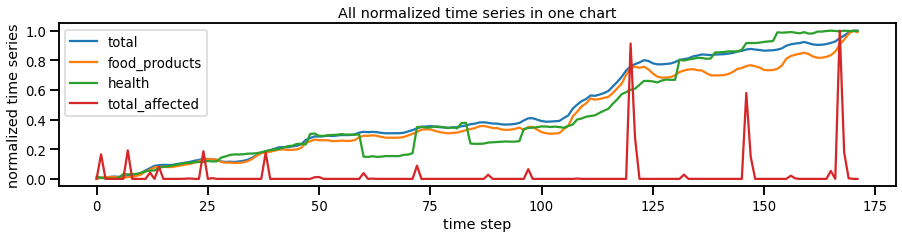

In [4]:
f,ax=plt.subplots(figsize=(15,3))
#df_norm.rolling(window=1,center=True).median().plot(ax=ax)
df_norm.plot(ax=ax)
ax.set(xlabel='time step',ylabel='normalized time series',title='All normalized time series in one chart');

In [8]:
'''found in https://stackoverflow.com/questions/48186624/pandas-rolling-window-spearman-correlation'''
def rolling_spearman_quick(seqa, seqb, window):
    stridea = seqa.strides[0]
    ssa = as_strided(seqa, shape=[len(seqa) - window + 1, window], strides=[stridea, stridea])
    strideb = seqa.strides[0]
    ssb = as_strided(seqb, shape=[len(seqb) - window + 1, window], strides =[strideb, strideb])
    ar = pd.DataFrame(ssa)
    br = pd.DataFrame(ssb)
    ar = ar.rank(1)
    br = br.rank(1)
    corrs = ar.corrwith(br, 1)
    return pad(corrs, (window - 1, 0), 'constant', constant_values=np.nan)

In [12]:
def plot_correlation(df_norm, time_series_1, time_series_2):
    # Set window size to compute moving window of x time steps.
    r_window_size = 20

    # Interpolate missing data.
    df_interpolated = df_norm.interpolate()

    # Compute rolling window 
    rolling_r = df_interpolated[time_series_1].rolling(window=r_window_size, center=True).corr(df_interpolated[time_series_2])

    f,ax=plt.subplots(2,1,figsize=(15,6),sharex=True)
    df_interpolated.rolling(window=1,center=True).median().plot(ax=ax[0])
    ax[0].set(xlabel='time step',ylabel='normalized time series')

    rolling_r.plot(ax=ax[1])
    ax[1].set(xlabel='Frame',ylabel='Spearman r')
    plt.axvline(x=r_window_size/2,color="r")
    plt.axvline(x=172-(r_window_size/2),color="g")
    plt.suptitle(f"Correlation over time for {time_series_1} and {time_series_2}")

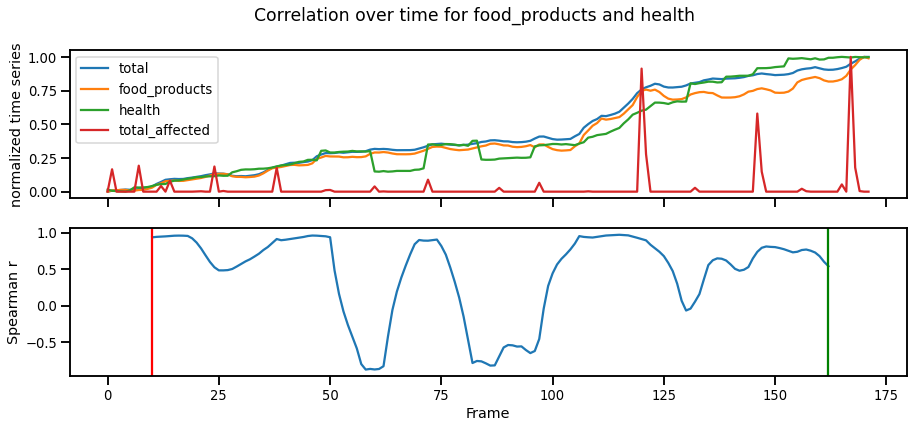

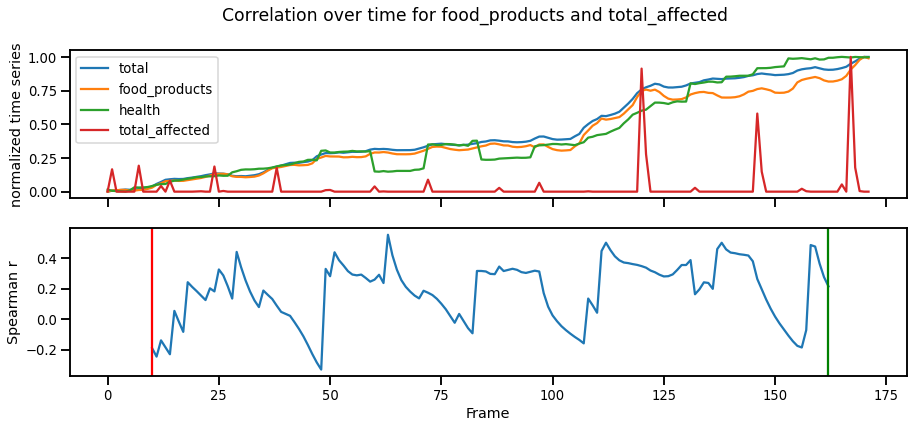

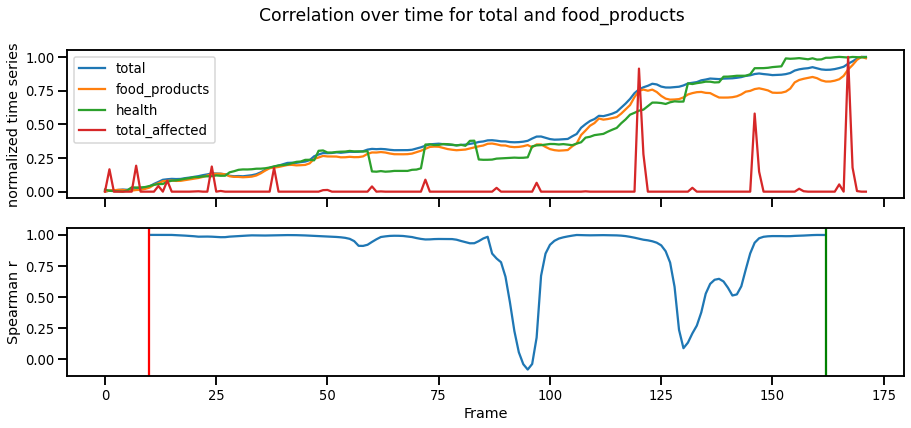

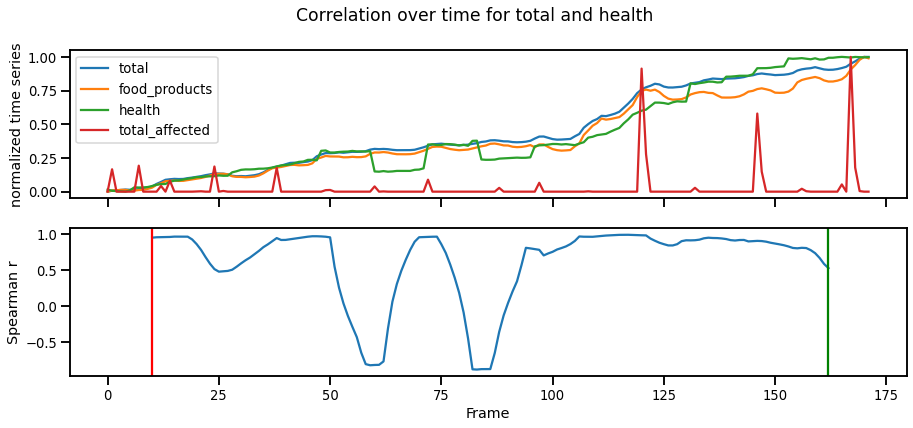

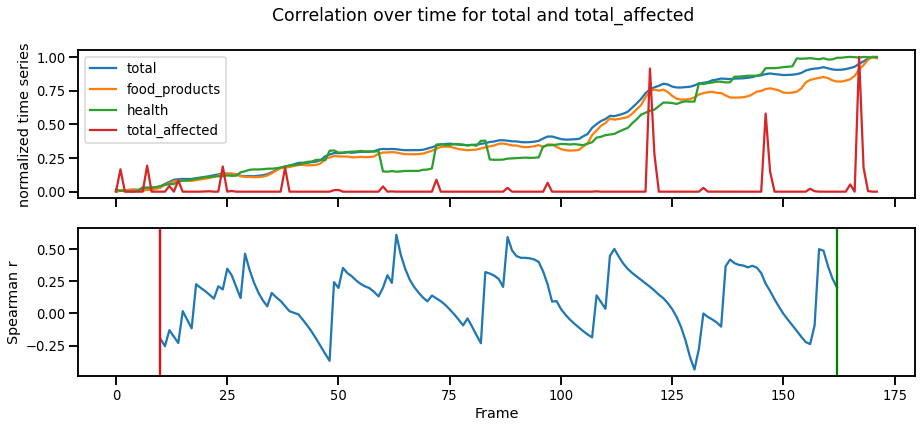

In [16]:
# plot the correlations
plot_correlation(df_norm, 'food_products', 'health')
plot_correlation(df_norm, 'food_products', 'total_affected')
plot_correlation(df_norm, 'total', 'food_products')
plot_correlation(df_norm, 'total', 'health')
plot_correlation(df_norm, 'total', 'total_affected')